In [1]:
import numpy as np
import pandas as pd
import subprocess
import tempfile
import multiprocessing

from primo.tools.barcoder import Barcoder

In [2]:
IP = "AGCACTCAGTATTTGTCCG"

In [3]:
barcode_order = pd.read_csv('/tf/primo/data/metadata/target_barcode_order.csv.gz')

In [4]:
barcoder = Barcoder(
    n_data_symbols   = 4,
    n_check_symbols  = 2,
    bits_per_symbol  = 6,
    bases_per_symbol = 5,
    seed = 42
)
def decode_barcode(barcode):
    return barcoder.barcode_seq_to_num(barcode.strip())

In [5]:
def decode_index(path_glob):
    
    with tempfile.NamedTemporaryFile() as temp:
        
        if path_glob.endswith(".gz"):
            cat_cmd = "zcat %s" % path_glob
        else:
            cat_cmd = "cat %s" % path_glob
    
        # extract barcodes
        subprocess.call(
            (cat_cmd + "| egrep -o '[ATCGN]{30}%s' | cut -b 1-30 > %s") % (
                IP,
                temp.name
            ),
            shell = True
        )
        
        barcodes = temp.readlines()
            
    # decode
    pool = multiprocessing.Pool()
    try:
        results = np.array(pool.map(decode_barcode, barcodes))
    finally:
        pool.close()
    
    decoded = results[results != None].astype(int)
    
    counts = np.bincount(decoded, minlength=len(barcode_order))[:len(barcode_order)]
    
    return counts

In [6]:
def decode_run(run_id):
    run_path = '/tf/primo/data/sequencing/%s/' % run_id
    
    # open run meta
    run_meta = pd.read_csv(run_path + 'index.csv')
    with open(run_path + 'location') as f:
        location = f.readline().strip()
        
    # decode each index
    counts = []
    for ix in run_meta.sequencing_index:
        print (run_id, ix)
        path_glob = location % ix
        counts.append(decode_index(path_glob))

    # save
    df = pd.DataFrame(
       np.array(counts),
       index = run_meta.sequencing_index,
       columns = barcode_order.ImageID
    )
    df.to_pickle(run_path + 'decoded.pkl.gz')
    
    return df

In [7]:
df = decode_run("Run_104")

('Run_104', 'B4')
('Run_104', 'C5')
('Run_104', 'D6')
('Run_104', 'E7')
('Run_104', 'F8')
('Run_104', 'H10')
('Run_104', 'B9')
('Run_104', 'D1')


In [14]:
df

ImageID,e39871fd9fd74f55,f18b91585c4d3f3e,ede6e66b2fb59aab,ed600d57fcee4f94,ff47e649b23f446d,e17acd05b631d330,efcfa9654f0e99c5,f4124588a82d57be,f7a1ee2daf06b9e5,e91ca52128724d8e,...,Unused,Unused,Unused,Unused,Unused,Unused,Unused,Unused,Unused,Randomer
sequencing_index,,,,,,,,,,,,,,,,,,,,,
B4,4,0,0,0,2,3,4,0,2,0,...,0,0,0,0,0,0,0,0,0,1144
C5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4635
D6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,595
E7,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,178
F8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2904
H10,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,578
B9,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1989
D1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5234


In [17]:
df['Randomer'] / df.sum(1)

sequencing_index
B4     0.000123
C5     0.001354
D6     0.000150
E7     0.000041
F8     0.001016
H10    0.000074
B9     0.000385
D1     0.001378
dtype: float64

In [18]:
df.sum(1) - df['Randomer']

sequencing_index
B4     9268728
C5     3419174
D6     3970384
E7     4311550
F8     2855643
H10    7854552
B9     5159398
D1     3791926
dtype: int64

In [20]:
df.values[0,:1600000]

array([[ 4,  0,  0, ..., 13,  4,  3],
       [ 0,  0,  0, ...,  1,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3,  0,  0],
       [ 0,  0,  0, ...,  4,  0,  1],
       [ 0,  0,  0, ...,  1,  0,  0]])

In [21]:
import matplotlib.pyplot as plt

(array([1.592311e+06, 5.778000e+03, 1.315000e+03, 4.000000e+02,
        1.160000e+02, 5.200000e+01, 1.500000e+01, 8.000000e+00,
        3.000000e+00, 2.000000e+00]),
 array([   0. ,  197.3,  394.6,  591.9,  789.2,  986.5, 1183.8, 1381.1,
        1578.4, 1775.7, 1973. ]),
 <a list of 10 Patch objects>)

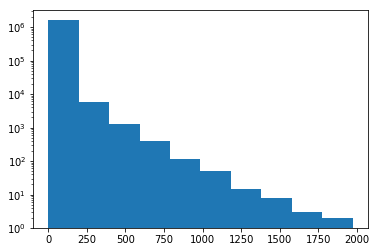

In [36]:
plt.hist(df.values[5,:1600000], log=True)